In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import nltk
from nltk.tokenize import word_tokenize
from datasets import load_dataset

In [2]:
### Hyper Params
batch_size = 1
hidden_size = 120
input_size = 120
embed_dim = 120
lr = 0.001
epochs = 10
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
raw_dataset = load_dataset("jaydenccc/AI_Storyteller_Dataset", split="train")['short_story']

In [4]:
nltk.download('punkt_tab')

text_corpus = ""
for item in raw_dataset:
    text_corpus += item.lower()

text_corpus = text_corpus.replace('.', '').replace(',','').replace('\n',' ').replace('\'', '').replace('\"', '').replace(':', '').replace('?', '').replace('!', '').replace(';', '').replace('-', '')

tokens = word_tokenize(text_corpus)
# tokens = [item for item in tokens if item not in ['the', '']]

unique_words = set(tokens)
word_to_num = {word: idx for idx, word in enumerate(unique_words)}
num_to_word = {idx: word for idx, word in enumerate(unique_words)}

[nltk_data] Downloading package punkt_tab to /home/grant/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [5]:
output_size = len(word_to_num)

pad_tok_id = output_size
num_to_word[pad_tok_id] = '<pad>'
word_to_num['<pad>'] = pad_tok_id

num_to_word[output_size+1] = ''
word_to_num[''] = output_size+1

output_size = len(word_to_num)

In [6]:
class StoryDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [7]:
# pads = ['<pad>' for i in range(9)]
corpus = text_corpus.split(' ')
# corpus = [item for item in corpus if item not in ['the', '']]

train_dataset = StoryDataset(corpus[:25000])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

test_dataset = StoryDataset(corpus[25000:])
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [34]:
class RNNModel(nn.Module):
    def __init__(self, embed_dim, vocab_size, hidden_size):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.RNN(embed_dim, hidden_size)
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.hidden_size = hidden_size

    def forward(self, x):
        embedded = self.embed(x)
        hidden = torch.zeros(1, 10, self.hidden_size).to(device)

        # Forward through net
        out, hidden = self.rnn(embedded, hidden)
        # print(f"RNN Out: {out.shape}")
        
        # Only use last hidden state for output
        out = self.fc(out[:, -1, :])
        # print(f"FC Out: {out.shape}")
        return out

In [35]:
net = RNNModel(embed_dim, output_size, hidden_size).to(device)
crit = nn.CrossEntropyLoss()
opt = optim.Adam(net.parameters(), lr=lr)

In [36]:
avg_loss = 0
net.train()
for epoch in range(epochs):
    for i in range(len(train_dataset)-10):
        input_seq = [word_to_num[v] for v in train_dataset[i:i+10]]
        target_tok = word_to_num[train_dataset[i+10]]
        
        input_tensor = torch.tensor(input_seq, dtype=torch.long).unsqueeze(0) # Shape [1, 10]
        target_tensor = torch.tensor(target_tok, dtype=torch.long).unsqueeze(0) # Shape [1]

        input_tensor, target_tensor = input_tensor.to(device), target_tensor.to(device)

        # print(f"Target tensor: {target_tensor}")
        
        opt.zero_grad()
        output = net(input_tensor)
        
        # Compute loss
        loss = crit(output, target_tensor)
        loss.backward()
        opt.step()
        
        avg_loss += loss.item()

        # if i % 100 == 0:
        #     print(f'Loss: {avg_loss/100}, Step: {i+(25000*epoch)}/{len(train_dataset)*epochs}, Epoch: {epoch}/{epochs-1}')
        #     avg_loss = 0
    
    print(f'Loss: {avg_loss/25000}, Epoch: {epoch+1}/{epochs}')
    # torch.save(net.state_dict(), f"rnn-nlp-epoch-{epoch}.pth")
    avg_loss = 0

Loss: 0.0866045093536377, Step: 0/25000, Epoch: 0/0
Loss: 8.450979671478272, Step: 100/25000, Epoch: 0/0
Loss: 8.135062236785888, Step: 200/25000, Epoch: 0/0
Loss: 7.754678263664245, Step: 300/25000, Epoch: 0/0
Loss: 7.792630143165589, Step: 400/25000, Epoch: 0/0
Loss: 7.238177635669708, Step: 500/25000, Epoch: 0/0
Loss: 7.262733550071716, Step: 600/25000, Epoch: 0/0
Loss: 6.759184019565582, Step: 700/25000, Epoch: 0/0
Loss: 7.087148329019547, Step: 800/25000, Epoch: 0/0
Loss: 7.095429793596268, Step: 900/25000, Epoch: 0/0
Loss: 6.692348681688308, Step: 1000/25000, Epoch: 0/0
Loss: 7.578595131635666, Step: 1100/25000, Epoch: 0/0
Loss: 6.867394018173218, Step: 1200/25000, Epoch: 0/0
Loss: 7.193477474451065, Step: 1300/25000, Epoch: 0/0
Loss: 7.087025964260102, Step: 1400/25000, Epoch: 0/0
Loss: 6.379844310879707, Step: 1500/25000, Epoch: 0/0
Loss: 6.6435691058635715, Step: 1600/25000, Epoch: 0/0
Loss: 7.0360314673185345, Step: 1700/25000, Epoch: 0/0
Loss: 6.813373584747314, Step: 1800/2

KeyboardInterrupt: 

In [ ]:
PATH = './next_word_2.pth'
torch.save(net.state_dict(), PATH)

In [ ]:
seq_len = 100
seq = []
cur = "protecting"

for i in range(seq_len):
    print(cur)
    next_tok = net(torch.tensor([[word_to_num[cur]]], dtype=torch.long).to(device))
    cur = num_to_word[torch.argmax(next_tok).item()]

In [ ]:
seq = train_dataset[0:10]
input_seq = [word_to_num[v] for v in seq]
input_tensor = torch.tensor(input_seq, dtype=torch.long).unsqueeze(0).to(device)
output = net(input_tensor)
num_to_word[torch.argmax(output).item()]

Word: the


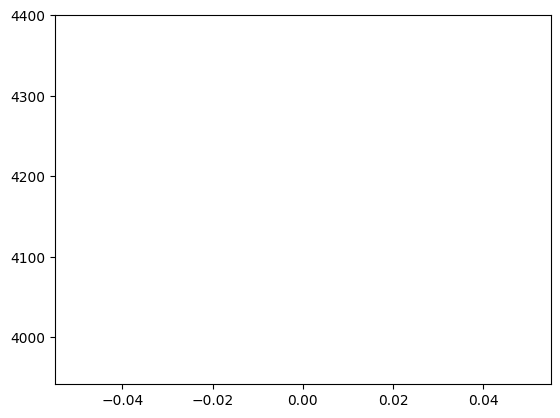

In [20]:
import matplotlib.pyplot as plt

input_tensor = torch.tensor([[word_to_num["the"]]], dtype=torch.float32)

# Forward pass
output = torch.argmax(net(input_tensor))
print(f'Word: {num_to_word[output.item()]}')

plot = output.detach().numpy()
plt.plot(plot)
plt.show()
# plt.figure(figsize=(10, 6))
# plt.bar(range(len(fc1_logits[0])), fc1_logits[0], color='blue', alpha=0.7)
# plt.title("Logits from fc1 Layer")
# plt.xlabel("Neuron Index")
# plt.ylabel("Logit Value")
# plt.show()

In [8]:
class Net(nn.Module):
    def __init__(self, input_size, output_size, embed_dim, vocab_size):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.fc = nn.Sequential(
            nn.Linear(input_size, 120),
            nn.GELU(),
            # nn.ReLU(),
            nn.Linear(120, 240),
            nn.GELU(),
            # nn.ReLU(),
            nn.Linear(240, output_size)
        )
    def forward(self, x):
        embedded = self.embed(x)
        embedded = embedded.view(embedded.size(0), -1)
        return self.fc(embedded)
        # return torch.argmax(x, dim=0)